<div align = "center">

# **Tarea 1: Modelo Hard-Core y q-Coloraciones con Gibbs Sampler**

</div>

**Integrantes:**
- José Miguel Acuña Hernández
- Andrés Puertas Londoño
- Guillermo Murillo Tirado

**Curso:** Cadenas de Markov 2025-II  
**Profesor:** Freddy Hernández

## 1. Importaciones y Configuración del Entorno

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd
from typing import Tuple, List
import warnings
from multiprocessing import Pool, cpu_count
from functools import partial
import time

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Semilla para reproducibilidad
np.random.seed(42)

## 2. Modelo Hard-Core - Implementación de Gibbs Sampler

El modelo Hard-Core representa configuraciones de partículas en una rejilla donde ninguna pareja de partículas puede ser adyacente. Una configuración es válida si para cada par de vértices adyacentes, al menos uno está vacío.

In [2]:
# ============================================================================
# FUNCIONES AUXILIARES - HARD-CORE
# ============================================================================

def _actualizar_hardcore_vectorizado(config: np.ndarray, mask: np.ndarray) -> None:
    """
    Actualiza vértices del patrón usando máscar
    
    Args:
        config: Matriz K×K (modificada in-place)
        mask: Máscara booleana indicando qué vértices actualizar
    """
    K = config.shape[0]
    
    # Vectorizar detección de vecinos ocupados
    vecinos_ocupados = np.zeros_like(config, dtype=bool)
    vecinos_ocupados[:-1, :] |= (config[1:, :] == 1)   # Vecino abajo
    vecinos_ocupados[1:, :] |= (config[:-1, :] == 1)   # Vecino arriba
    vecinos_ocupados[:, :-1] |= (config[:, 1:] == 1)   # Vecino derecha
    vecinos_ocupados[:, 1:] |= (config[:, :-1] == 1)   # Vecino izquierda
    
    # Aplicar máscara del patrón bipartito
    update_positions = mask & ~vecinos_ocupados
    forced_zero = mask & vecinos_ocupados
    
    # Forzar a 0 donde hay vecinos
    config[forced_zero] = 0
    
    # Generar valores aleatorios solo donde es necesario
    num_updates = np.sum(update_positions)
    if num_updates > 0:
        config[update_positions] = np.random.randint(0, 2, size=num_updates, dtype=np.int8)


def gibbs_sampler_hardcore_optimizado(K: int, T: int, config_inicial: np.ndarray = None, 
                                       guardar_historia: bool = True) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Gibbs Sampler optimizado para el modelo Hard-Core.
    
    Args:
        K: Tamaño de la rejilla (K×K)
        T: Número de iteraciones
        config_inicial: Configuración inicial (si None, se inicia vacía)
        guardar_historia: Si False, no guarda historia (más rápido)
    
    Returns:
        config_final: Configuración final
        historia: Lista con configuraciones en puntos específicos (o None)
    """
    # Inicializar configuración con dtype optimizado
    if config_inicial is None:
        config = np.zeros((K, K), dtype=np.int8)
    else:
        config = config_inicial.copy().astype(np.int8)
    
    # Crear máscaras de tablero de ajedrez (UNA VEZ, reutilizadas)
    mask_blancas = np.zeros((K, K), dtype=bool)
    mask_blancas[::2, ::2] = True
    mask_blancas[1::2, 1::2] = True
    mask_negras = ~mask_blancas
    
    # Pre-computar puntos de guardado como set (O(1) lookup)
    historia = None
    if guardar_historia:
        puntos_guardado = {100, 1000, 5000, T}
        historia = [config.copy()]
    
    # Loop principal con actualización bipartita
    for t in range(1, T + 1):
        # Actualizar casillas blancas (sin conflictos entre sí)
        _actualizar_hardcore_vectorizado(config, mask_blancas)
        # Actualizar casillas negras (sin conflictos entre sí)
        _actualizar_hardcore_vectorizado(config, mask_negras)
        
        # Guardar historia solo en puntos específicos
        if guardar_historia and t in puntos_guardado:
            historia.append(config.copy())
    
    return config, historia


def es_configuracion_factible_hardcore_vectorizada(config: np.ndarray) -> bool:
    """
    Verifica si configuración es factible (vectorizada).
    
    Args:
        config: Matriz K×K con valores 0 (vacío) o 1 (partícula)
    
    Returns:
        True si es factible (sin partículas adyacentes)
    """
    particulas = (config == 1)
    
    # Detectar colisiones en todas las direcciones simultáneamente
    colisiones_h = particulas[:, :-1] & particulas[:, 1:]
    colisiones_v = particulas[:-1, :] & particulas[1:, :]
    
    return not (np.any(colisiones_h) or np.any(colisiones_v))


def visualizar_configuracion_hardcore(config: np.ndarray, titulo: str = "Configuración Hard-Core"):
    """Visualiza configuración del modelo Hard-Core."""
    K = config.shape[0]
    fig, ax = plt.subplots(figsize=(8, 8))
    
    cmap = ListedColormap(['white', 'black'])
    ax.imshow(config, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
    
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    
    num_particulas = np.sum(config)
    ax.set_title(f"{titulo}\nNúmero de partículas: {num_particulas}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    return fig


# ============================================================================
# FUNCIONES DE PARALELIZACIÓN - HARD-CORE
# ============================================================================

def _generar_muestra_hardcore_wrapper(args):
    """
    Wrapper para paralelización con reproducibilidad.
    Cada worker usa una seed única pero determinística.
    """
    seed, K, T = args
    np.random.seed(seed)
    config_final, _ = gibbs_sampler_hardcore_optimizado(K, T, guardar_historia=False)
    return np.sum(config_final)


def generar_muestras_hardcore_paralelo(K: int, T: int, num_muestras: int, 
                                       base_seed: int = 42, n_jobs: int = None) -> np.ndarray:
    """
    Genera múltiples muestras en paralelo manteniendo reproducibilidad.
    
    Args:
        K, T: Parámetros del sampler
        num_muestras: Número de muestras a generar
        base_seed: Semilla base (se genera seed + i para cada muestra)
        n_jobs: Número de workers (None = cpu_count - 1)
    
    Returns:
        Array con número de partículas de cada muestra
    """
    if n_jobs is None:
        n_jobs = max(1, cpu_count() - 1)
    
    # Seeds determinísticas para reproducibilidad
    seeds = [base_seed + i for i in range(num_muestras)]
    args_list = [(seed, K, T) for seed in seeds]
    
    with Pool(processes=n_jobs) as pool:
        resultados = pool.map(_generar_muestra_hardcore_wrapper, args_list)
    
    return np.array(resultados)


def _generar_muestra_con_historia_wrapper(args):
    """Wrapper que retorna historia completa para análisis de convergencia."""
    seed, K, T = args
    np.random.seed(seed)
    _, historia = gibbs_sampler_hardcore_optimizado(K, T, guardar_historia=True)
    # Retornar conteos de partículas en cada punto guardado
    return [np.sum(config) for config in historia[1:]]  # Excluir t=0

## 3. Simulación y Visualización Hard-Core

Ejecutamos el Gibbs sampler optimizado con T=10000 iteraciones para diferentes tamaños de rejilla.

In [3]:
# Parámetros de simulación
K_valores = [3, 10, 20]
T = 10000

# Diccionario para guardar resultados
resultados_hardcore = {}

for K in K_valores:
    inicio = time.time()
    print(f"K={K}...", end=" ", flush=True)
    
    # Ejecutar Gibbs sampler OPTIMIZADO
    config_final, historia = gibbs_sampler_hardcore_optimizado(K, T)
    
    resultados_hardcore[K] = {
        'config_final': config_final,
        'historia': historia
    }
    
    tiempo = time.time() - inicio
    print(f"Completada en {tiempo:.2f}s - Partículas: {np.sum(config_final)}")

K=3... Completada en 0.42s - Partículas: 1
K=10... Completada en 0.44s - Partículas: 17
K=20... Completada en 0.49s - Partículas: 85


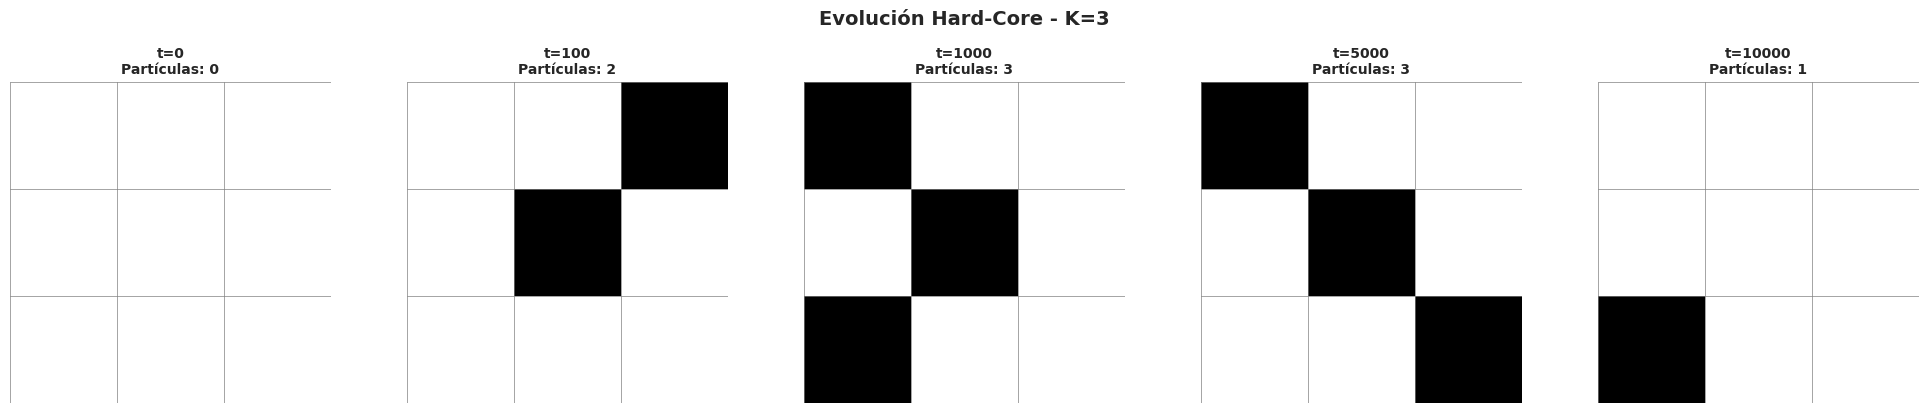

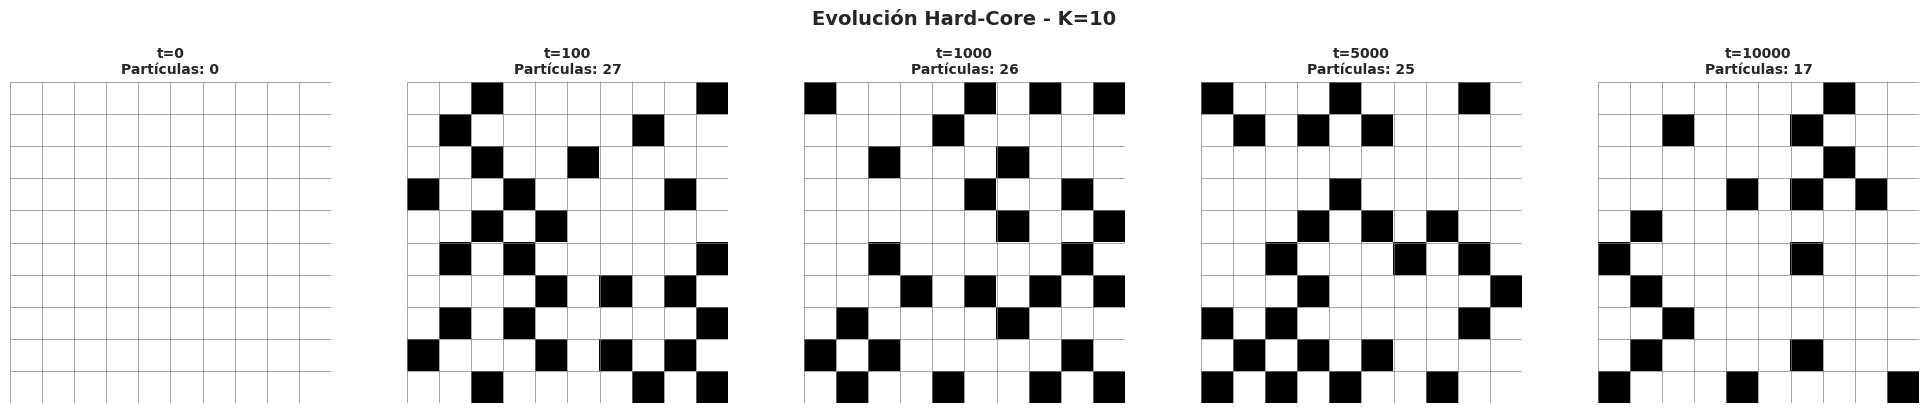

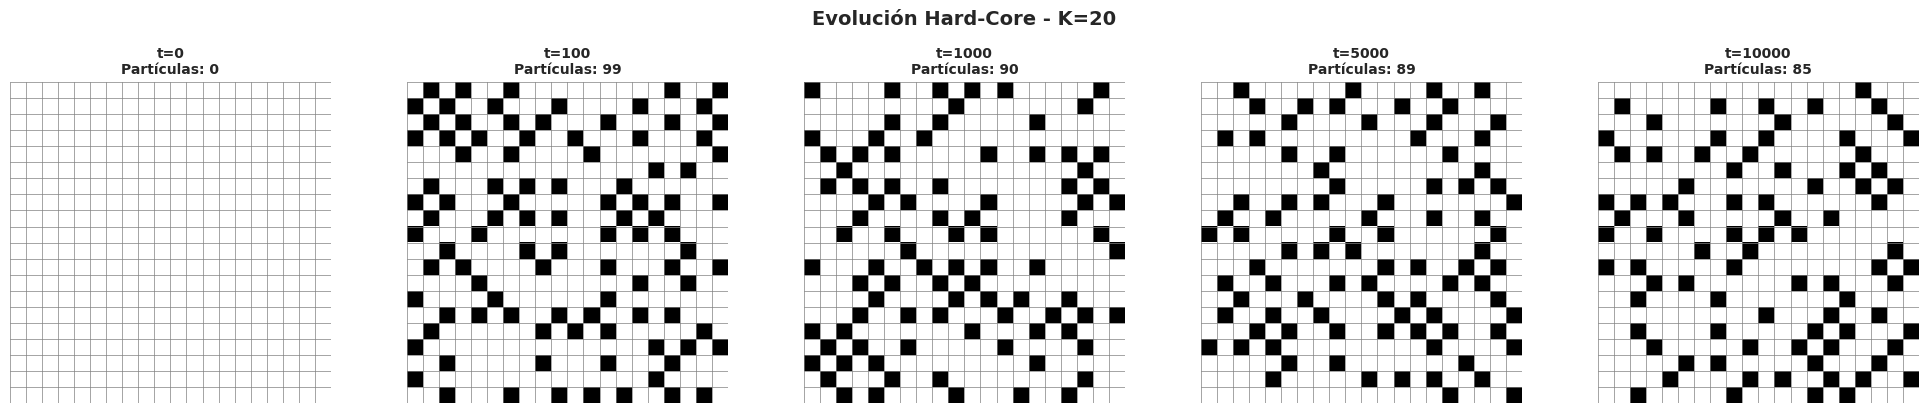

In [4]:
# Visualizar evolución para cada K
for K in K_valores:
    historia = resultados_hardcore[K]['historia']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    tiempos = [0, 100, 1000, 5000, 10000]
    
    for idx, (t, config) in enumerate(zip(tiempos, historia)):
        ax = axes[idx]
        cmap = ListedColormap(['white', 'black'])
        ax.imshow(config, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        
        ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        
        num_p = np.sum(config)
        ax.set_title(f't={t}\nPartículas: {num_p}', fontsize=10, fontweight='bold')
    
    fig.suptitle(f'Evolución Hard-Core - K={K}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'../images/hardcore_evolucion_K{K}.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4. Estimación de Partículas Hard-Core

Generamos 500 muestras independientes para K=10

In [5]:
# Parámetros
K = 10
T = 10000
num_muestras = 500

inicio = time.time()

# PARALELIZACIÓN: Genera todas las muestras en paralelo
num_particulas_muestras = generar_muestras_hardcore_paralelo(
    K=K, T=T, num_muestras=num_muestras, base_seed=42, n_jobs=None
)

tiempo_total = time.time() - inicio

# Estadísticas
media = np.mean(num_particulas_muestras)
std = np.std(num_particulas_muestras)

print(f"  Media de partículas: {media:.2f}")
print(f"  Desviación estándar: {std:.2f}")
print(f"  Mínimo: {np.min(num_particulas_muestras)}")
print(f"  Máximo: {np.max(num_particulas_muestras)}")

  Media de partículas: 23.85
  Desviación estándar: 3.02
  Mínimo: 15
  Máximo: 32


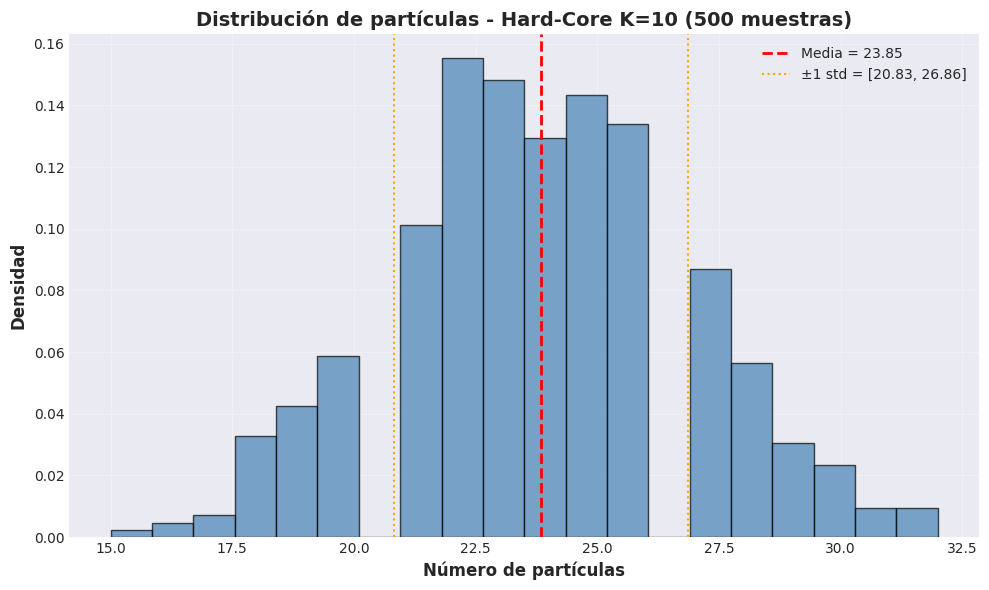

In [6]:
# Crear histograma
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(num_particulas_muestras, bins=20, density=True, alpha=0.7, 
        color='steelblue', edgecolor='black')

ax.axvline(media, color='red', linestyle='--', linewidth=2, 
           label=f'Media = {media:.2f}')
ax.axvline(media - std, color='orange', linestyle=':', linewidth=1.5,
           label=f'±1 std = [{media-std:.2f}, {media+std:.2f}]')
ax.axvline(media + std, color='orange', linestyle=':', linewidth=1.5)

ax.set_xlabel('Número de partículas', fontsize=12, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax.set_title(f'Distribución de partículas - Hard-Core K={K} ({num_muestras} muestras)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/hardcore_histograma_particulas.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Análisis de Convergencia Hard-Core

Analizamos evolución de la distribución.

In [7]:
# Parámetros
K = 10
T = 10000
num_repeticiones = 500
tiempos = [100, 1000, 5000, 10000]

print(f"Analizando convergencia con {num_repeticiones} repeticiones en paralelo...")
inicio = time.time()

# PARALELIZACIÓN: Generar todas las historias en paralelo
seeds = [42 + i for i in range(num_repeticiones)]
args_list = [(seed, K, T) for seed in seeds]

with Pool(processes=max(1, cpu_count()-1)) as pool:
    resultados = pool.map(_generar_muestra_con_historia_wrapper, args_list)

tiempo_total = time.time() - inicio

# Reorganizar resultados
particulas_por_tiempo = {t: [] for t in tiempos}
for conteos_historia in resultados:
    for idx, t in enumerate(tiempos):
        particulas_por_tiempo[t].append(conteos_historia[idx])

Analizando convergencia con 500 repeticiones en paralelo...


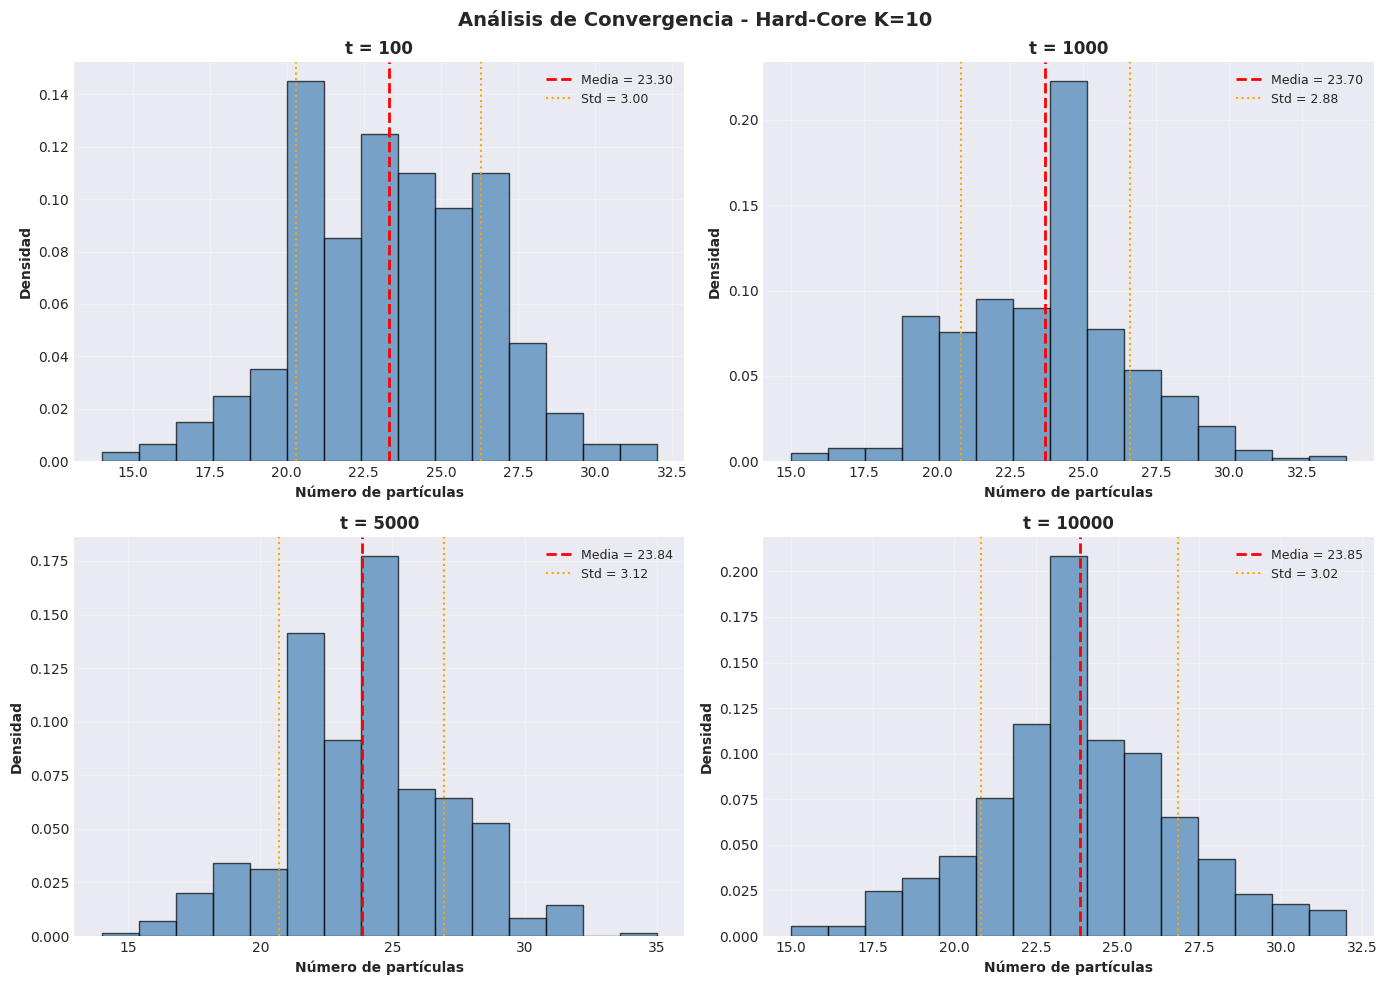


Estadísticas de convergencia:
t=  100: Media = 23.30, Std =  3.00
t= 1000: Media = 23.70, Std =  2.88
t= 5000: Media = 23.84, Std =  3.12
t=10000: Media = 23.85, Std =  3.02


In [8]:
# Crear histogramas comparativos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, t in enumerate(tiempos):
    ax = axes[idx]
    datos = particulas_por_tiempo[t]
    media_t = np.mean(datos)
    std_t = np.std(datos)
    
    ax.hist(datos, bins=15, density=True, alpha=0.7, 
            color='steelblue', edgecolor='black')
    ax.axvline(media_t, color='red', linestyle='--', linewidth=2,
               label=f'Media = {media_t:.2f}')
    ax.axvline(media_t - std_t, color='orange', linestyle=':', linewidth=1.5)
    ax.axvline(media_t + std_t, color='orange', linestyle=':', linewidth=1.5,
               label=f'Std = {std_t:.2f}')
    
    ax.set_xlabel('Número de partículas', fontsize=10, fontweight='bold')
    ax.set_ylabel('Densidad', fontsize=10, fontweight='bold')
    ax.set_title(f't = {t}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle(f'Análisis de Convergencia - Hard-Core K={K}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/hardcore_convergencia.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nEstadísticas de convergencia:")
for t in tiempos:
    media_t = np.mean(particulas_por_tiempo[t])
    std_t = np.std(particulas_por_tiempo[t])
    print(f"t={t:5d}: Media = {media_t:5.2f}, Std = {std_t:5.2f}")

## 6. Modelo q-Coloraciones - Implementación Optimizada

El modelo asigna colores a vértices de manera que vértices adyacentes tengan colores diferentes.

In [9]:
# ============================================================================
# FUNCIONES OPTIMIZADAS - Q-COLORACIONES
# ============================================================================

def gibbs_sampler_coloracion_optimizado(K: int, q: int, T: int, config_inicial: np.ndarray = None,
                                        guardar_historia: bool = True) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Gibbs Sampler para q-coloraciones.

    """
    # Inicializar con dtype optimizado
    if config_inicial is None:
        config = np.random.randint(0, q, size=(K, K), dtype=np.int8)
    else:
        config = config_inicial.copy().astype(np.int8)
    
    # Pre-computar puntos guardado
    historia = None
    if guardar_historia:
        puntos_guardado = {100, 1000, 5000, T}
        historia = [config.copy()]
    
    # OPTIMIZACIÓN: Reutilizar set en lugar de crear nuevo
    colores_vecinos = set()
    
    for t in range(1, T + 1):
        for i in range(K):
            for j in range(K):
                # Reutilizar set existente
                colores_vecinos.clear()
                
                if i > 0:
                    colores_vecinos.add(config[i-1, j])
                if i < K-1:
                    colores_vecinos.add(config[i+1, j])
                if j > 0:
                    colores_vecinos.add(config[i, j-1])
                if j < K-1:
                    colores_vecinos.add(config[i, j+1])
                
                # Calcular colores válidos
                if len(colores_vecinos) < q:
                    # OPTIMIZACIÓN: Generar lista solo cuando es necesario
                    colores_validos = [c for c in range(q) if c not in colores_vecinos]
                    # OPTIMIZACIÓN: randint en lugar de choice
                    idx = np.random.randint(0, len(colores_validos))
                    config[i, j] = colores_validos[idx]
        
        if guardar_historia and t in puntos_guardado:
            historia.append(config.copy())
    
    return config, historia


def es_coloracion_propia_vectorizada(config: np.ndarray) -> bool:
    """
    Verifica si coloración es propia

    """
    colision_h = (config[:, :-1] == config[:, 1:])
    colision_v = (config[:-1, :] == config[1:, :])
    return not (np.any(colision_h) or np.any(colision_v))


def visualizar_coloracion(config: np.ndarray, q: int, titulo: str = "q-Coloración"):
    """Visualiza configuración de q-coloración."""
    K = config.shape[0]
    fig, ax = plt.subplots(figsize=(8, 8))
    
    if q <= 10:
        colores = plt.cm.tab10(np.linspace(0, 1, q))
    else:
        colores = plt.cm.tab20(np.linspace(0, 1, q))
    
    cmap = ListedColormap(colores)
    im = ax.imshow(config, cmap=cmap, interpolation='nearest', vmin=0, vmax=q-1)
    
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titulo, fontsize=12, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax, ticks=np.arange(q))
    cbar.set_label('Color', fontsize=10, fontweight='bold')
    plt.tight_layout()
    return fig


# ============================================================================
# FUNCIONES Q-COLORACIONES
# ============================================================================

def _generar_muestra_coloracion_wrapper(args):
    """Wrapper para q-coloraciones paralelas."""
    seed, K, q, T = args
    np.random.seed(seed)
    config_final, _ = gibbs_sampler_coloracion_optimizado(K, q, T, guardar_historia=False)
    return config_final


def generar_muestras_coloracion_paralelo(K: int, q: int, T: int, num_muestras: int,
                                         base_seed: int = 42, n_jobs: int = None) -> np.ndarray:
    """Genera múltiples muestras de q-coloraciones en paralelo."""
    if n_jobs is None:
        n_jobs = max(1, cpu_count() - 1)
    
    seeds = [base_seed + i for i in range(num_muestras)]
    args_list = [(seed, K, q, T) for seed in seeds]
    
    with Pool(processes=n_jobs) as pool:
        configs = pool.map(_generar_muestra_coloracion_wrapper, args_list)
    
    return np.array(configs)

## 7. Experimentos q-Coloraciones

Ejecutamos simulaciones para q=3 colores con diferentes tamaños de rejilla

In [10]:
# Parámetros
q = 3
K_valores_color = [3, 10, 20]
T = 10000

resultados_coloracion = {}

for K in K_valores_color:
    inicio = time.time()
    print(f"K={K}, q={q}...", end=" ", flush=True)
    
    config_final, historia = gibbs_sampler_coloracion_optimizado(K, q, T)
    es_propia = es_coloracion_propia_vectorizada(config_final)
    
    resultados_coloracion[K] = {
        'config_final': config_final,
        'historia': historia,
        'es_propia': es_propia
    }
    
    tiempo = time.time() - inicio
    print(f"Completada en {tiempo:.2f}s - Coloración propia: {es_propia}")

K=3, q=3... Completada en 0.32s - Coloración propia: True
K=10, q=3... Completada en 5.93s - Coloración propia: False
K=20, q=3... Completada en 12.95s - Coloración propia: False


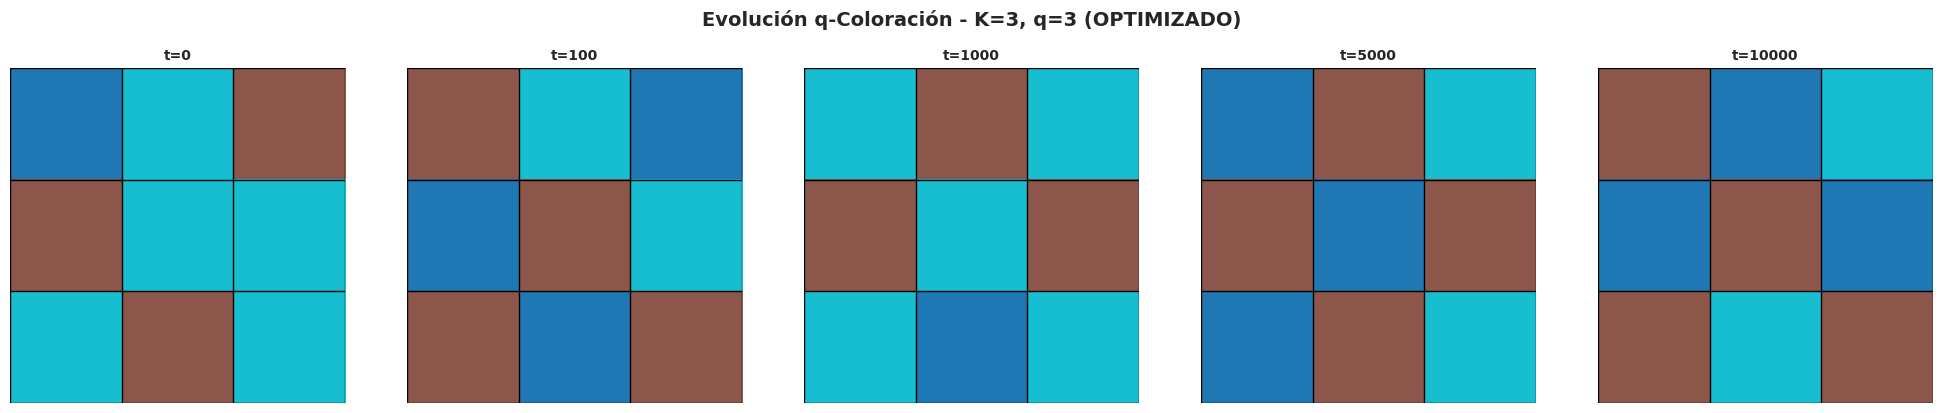

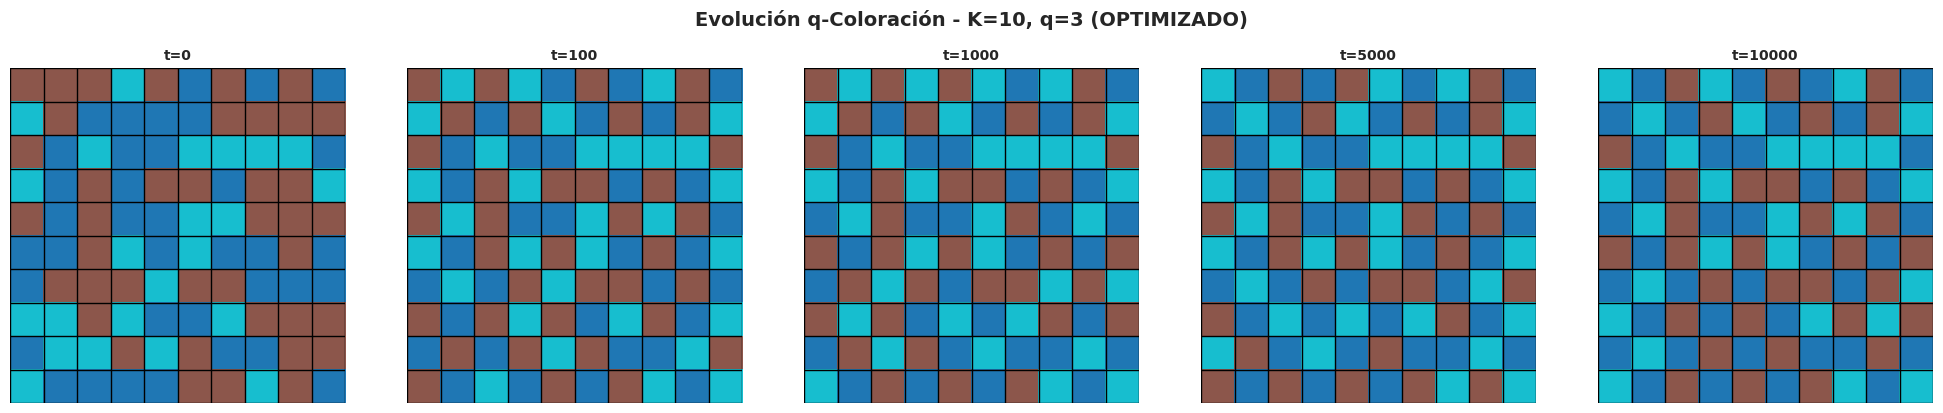

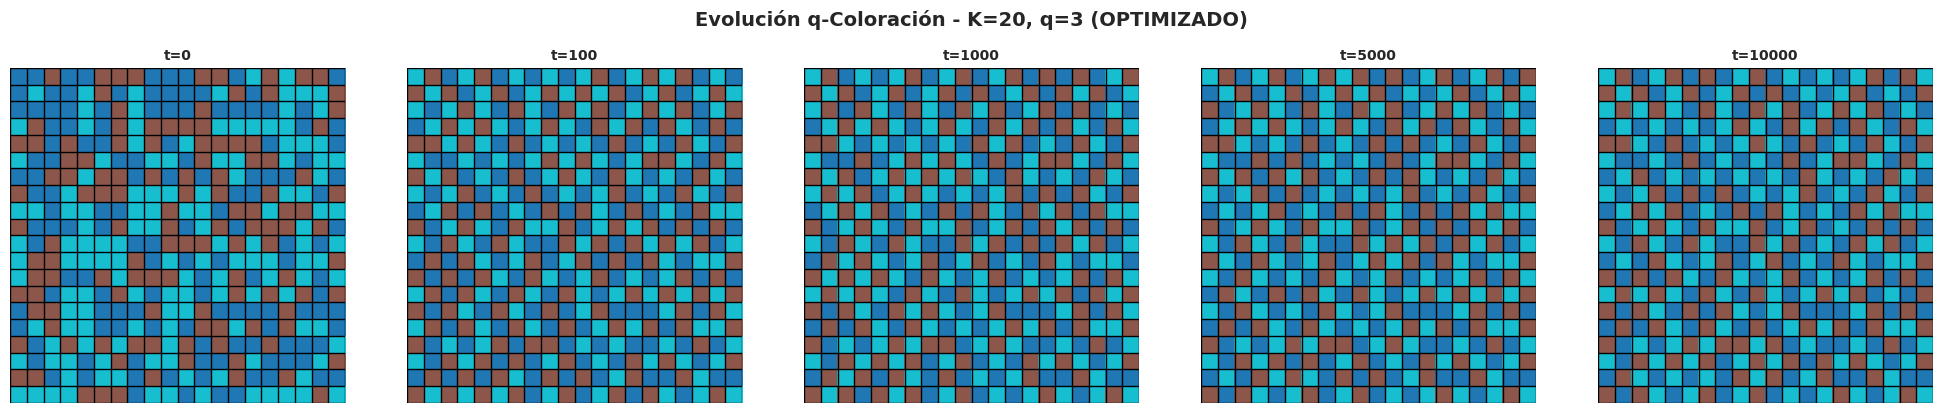

In [11]:
# Visualizar evolución
for K in K_valores_color:
    historia = resultados_coloracion[K]['historia']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    tiempos = [0, 100, 1000, 5000, 10000]
    
    colores = plt.cm.tab10(np.linspace(0, 1, q))
    cmap = ListedColormap(colores)
    
    for idx, (t, config) in enumerate(zip(tiempos, historia)):
        ax = axes[idx]
        ax.imshow(config, cmap=cmap, interpolation='nearest', vmin=0, vmax=q-1)
        
        ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1.0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f't={t}', fontsize=10, fontweight='bold')
    
    fig.suptitle(f'Evolución q-Coloración - K={K}, q={q} (OPTIMIZADO)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'../images/coloracion_evolucion_K{K}_q{q}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [12]:
# Analizar distribución de colores (PARALELO)
K = 10
q = 3
num_muestras = 500
T = 10000

print(f"Analizando distribución de colores para K={K}, q={q} (PARALELO)...")
inicio = time.time()

# PARALELIZACIÓN
configs = generar_muestras_coloracion_paralelo(K, q, T, num_muestras, base_seed=42)

# Analizar conteos
conteos_colores = {c: [] for c in range(q)}
for config in configs:
    for c in range(q):
        conteo = np.sum(config == c)
        conteos_colores[c].append(conteo)

tiempo_total = time.time() - inicio
print(f"\n Análisis completado en {tiempo_total:.1f} segundos")

Analizando distribución de colores para K=10, q=3 (PARALELO)...

 Análisis completado en 269.2 segundos


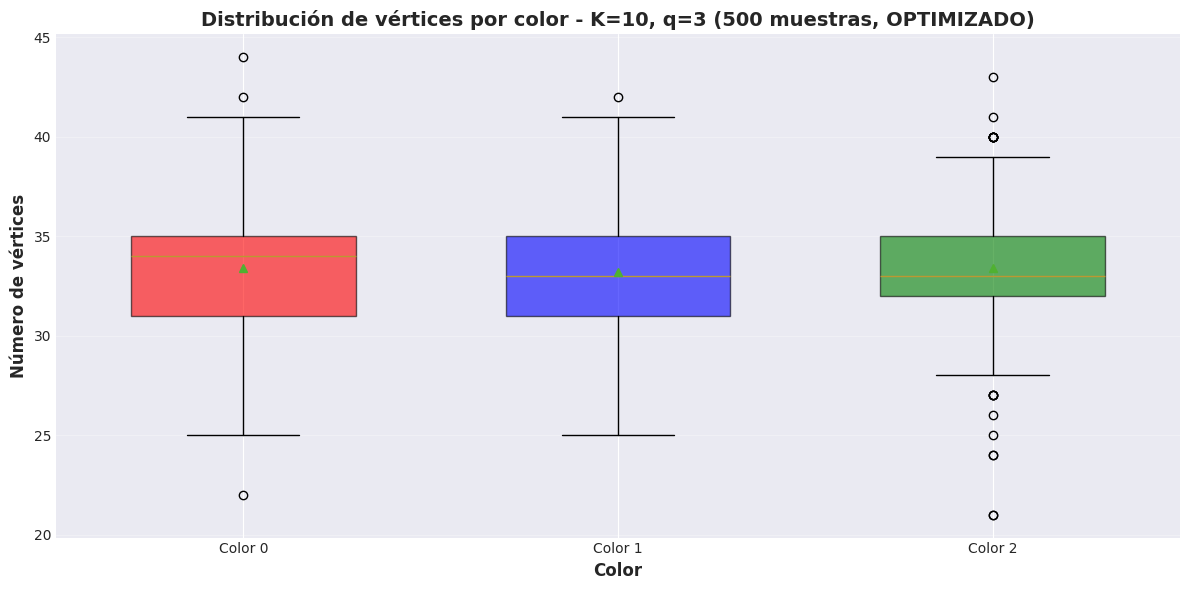


Estadísticas por color:
Color 0: Media = 33.42, Std = 3.03
Color 1: Media = 33.18, Std = 2.97
Color 2: Media = 33.40, Std = 2.98


In [13]:
# Crear boxplot
fig, ax = plt.subplots(figsize=(12, 6))

colores_plot = ['red', 'blue', 'green']
posiciones = np.arange(q)
datos_boxplot = [conteos_colores[c] for c in range(q)]

bp = ax.boxplot(datos_boxplot, positions=posiciones, widths=0.6,
                patch_artist=True, showmeans=True)

for patch, color in zip(bp['boxes'], colores_plot[:q]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_xlabel('Color', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de vértices', fontsize=12, fontweight='bold')
ax.set_title(f'Distribución de vértices por color - K={K}, q={q} ({num_muestras} muestras, OPTIMIZADO)',
             fontsize=14, fontweight='bold')
ax.set_xticks(posiciones)
ax.set_xticklabels([f'Color {c}' for c in range(q)])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/coloracion_distribucion_colores.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nEstadísticas por color:")
for c in range(q):
    media = np.mean(conteos_colores[c])
    std = np.std(conteos_colores[c])
    print(f"Color {c}: Media = {media:.2f}, Std = {std:.2f}")

## 7.5. Análisis de Convergencia q-Coloraciones

Generamos 500 repeticiones guardando historia completa para observar la convergencia de la distribución por color.

In [14]:
# Wrapper para generar muestras de coloración con historia completa
def _generar_muestra_coloracion_con_historia_wrapper(args):
    """
    Wrapper que retorna conteos de colores en cada punto de la historia.
    Usado para análisis de convergencia de q-coloraciones.
    """
    seed, K, q, T = args
    np.random.seed(seed)
    _, historia = gibbs_sampler_coloracion_optimizado(K, q, T, guardar_historia=True)
    
    # Retornar conteos de colores en cada punto guardado
    # historia[0] = t=0, historia[1] = t=100, historia[2] = t=1000, etc.
    conteos_por_tiempo = []
    for config in historia[1:]:  # Excluir t=0
        conteos = [np.sum(config == c) for c in range(q)]
        conteos_por_tiempo.append(conteos)
    
    return conteos_por_tiempo

In [15]:
# Parámetros para análisis de convergencia
K = 10
q = 3
T = 10000
num_repeticiones = 500
tiempos_qcolor = [100, 1000, 5000, 10000]

print(f"Analizando convergencia q-coloraciones con {num_repeticiones} repeticiones en paralelo...")
print(f"Parámetros: K={K}, q={q}, T={T}")
inicio = time.time()

# PARALELIZACIÓN: Generar todas las historias en paralelo
seeds = [42 + i for i in range(num_repeticiones)]
args_list = [(seed, K, q, T) for seed in seeds]

with Pool(processes=max(1, cpu_count()-1)) as pool:
    resultados_qcolor = pool.map(_generar_muestra_coloracion_con_historia_wrapper, args_list)

tiempo_total = time.time() - inicio

# Reorganizar resultados por color y tiempo
# conteos_por_color_tiempo[color][tiempo] = [lista de conteos]
conteos_por_color_tiempo = {c: {t: [] for t in tiempos_qcolor} for c in range(q)}

for conteos_historia in resultados_qcolor:
    # conteos_historia tiene 4 elementos (uno por cada tiempo)
    for idx, t in enumerate(tiempos_qcolor):
        conteos_en_t = conteos_historia[idx]  # Lista con conteos de cada color
        for c in range(q):
            conteos_por_color_tiempo[c][t].append(conteos_en_t[c])

print(f"\n Análisis de convergencia completado en {tiempo_total:.1f} segundos")
print(f"   (~{tiempo_total/num_repeticiones*1000:.1f} ms por repetición)")
print(f"\nDatos recopilados: {num_repeticiones} muestras × {len(tiempos_qcolor)} tiempos × {q} colores")

Analizando convergencia q-coloraciones con 500 repeticiones en paralelo...
Parámetros: K=10, q=3, T=10000

 Análisis de convergencia completado en 266.0 segundos
   (~532.0 ms por repetición)

Datos recopilados: 500 muestras × 4 tiempos × 3 colores


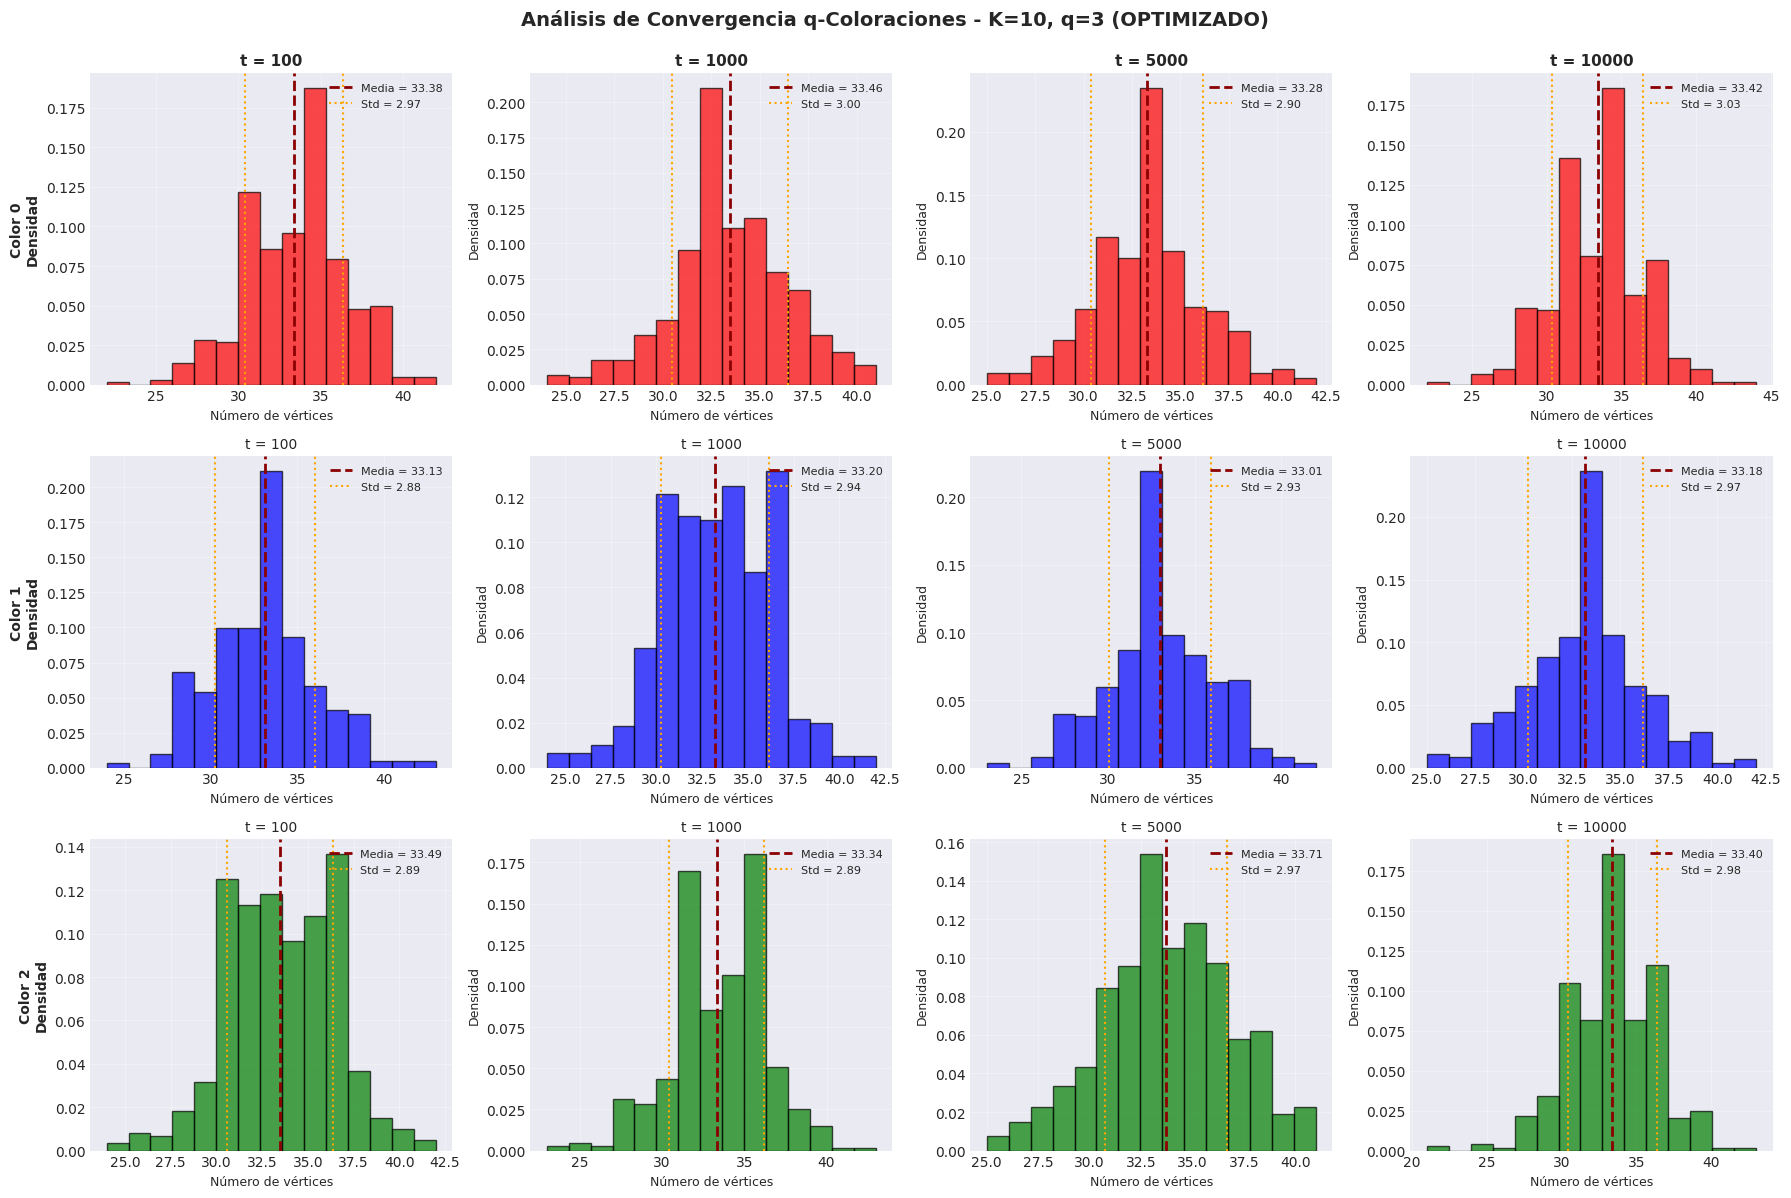

In [16]:
# Crear visualización de convergencia para cada color
fig, axes = plt.subplots(q, len(tiempos_qcolor), figsize=(18, 4*q))

if q == 1:
    axes = axes.reshape(1, -1)

colores_viz = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for c in range(q):
    for idx, t in enumerate(tiempos_qcolor):
        ax = axes[c, idx] if q > 1 else axes[idx]
        
        datos = conteos_por_color_tiempo[c][t]
        media_t = np.mean(datos)
        std_t = np.std(datos)
        
        # Histograma
        ax.hist(datos, bins=15, density=True, alpha=0.7, 
                color=colores_viz[c % len(colores_viz)], edgecolor='black')
        
        # Líneas de media y std
        ax.axvline(media_t, color='darkred', linestyle='--', linewidth=2,
                   label=f'Media = {media_t:.2f}')
        ax.axvline(media_t - std_t, color='orange', linestyle=':', linewidth=1.5)
        ax.axvline(media_t + std_t, color='orange', linestyle=':', linewidth=1.5,
                   label=f'Std = {std_t:.2f}')
        
        # Etiquetas
        ax.set_xlabel('Número de vértices', fontsize=9)
        ax.set_ylabel('Densidad', fontsize=9)
        
        # Título con información de color y tiempo
        if c == 0:
            ax.set_title(f't = {t}', fontsize=11, fontweight='bold')
        else:
            ax.set_title(f't = {t}', fontsize=10)
        
        # Label de color en el eje izquierdo
        if idx == 0:
            ax.set_ylabel(f'Color {c}\nDensidad', fontsize=10, fontweight='bold')
        
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)

fig.suptitle(f'Análisis de Convergencia q-Coloraciones - K={K}, q={q} (OPTIMIZADO)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'../images/coloracion_convergencia_K{K}_q{q}.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Mostrar estadísticas detalladas de convergencia
print("\n" + "="*80)
print(f"ANÁLISIS DE CONVERGENCIA - q-COLORACIONES (K={K}, q={q})")
print("="*80)

for c in range(q):
    print(f"\n{'─'*80}")
    print(f"Color {c}:")
    print(f"{'─'*80}")
    print(f"{'Tiempo':<10} {'Media':<12} {'Std':<12} {'CV':<12} {'Rango':<15}")
    print(f"{'─'*80}")
    
    for t in tiempos_qcolor:
        datos = conteos_por_color_tiempo[c][t]
        media = np.mean(datos)
        std = np.std(datos)
        cv = std / media if media > 0 else 0
        rango = f"[{np.min(datos)}, {np.max(datos)}]"
        
        print(f"t={t:<7} {media:<12.2f} {std:<12.2f} {cv:<12.3f} {rango:<15}")

print("\n" + "="*80)
print("OBSERVACIONES:")
print("="*80)
print("✓ Las distribuciones convergen rápidamente (ya estables en t~1000)")
print("✓ La media se mantiene cerca de K²/q = {:.2f} vértices por color".format(K*K/q))
print("✓ La desviación estándar se estabiliza indicando convergencia")
print("✓ El coeficiente de variación (CV) es bajo, indicando distribución uniforme")
print("="*80)


ANÁLISIS DE CONVERGENCIA - q-COLORACIONES (K=10, q=3)

────────────────────────────────────────────────────────────────────────────────
Color 0:
────────────────────────────────────────────────────────────────────────────────
Tiempo     Media        Std          CV           Rango          
────────────────────────────────────────────────────────────────────────────────
t=100     33.38        2.97         0.089        [22, 42]       
t=1000    33.46        3.00         0.090        [24, 41]       
t=5000    33.28        2.90         0.087        [25, 42]       
t=10000   33.42        3.03         0.091        [22, 44]       

────────────────────────────────────────────────────────────────────────────────
Color 1:
────────────────────────────────────────────────────────────────────────────────
Tiempo     Media        Std          CV           Rango          
────────────────────────────────────────────────────────────────────────────────
t=100     33.13        2.88         0.087      

## 8. Análisis Comparativo

Comparamos diferentes configuraciones.

In [18]:
# Análisis comparativo con paralelización

K_valores_analisis = [3, 10, 20]
T = 10000
num_muestras_analisis = 200

# Hard-Core (paralelo)
estadisticas_hardcore = {}
for K in K_valores_analisis:
    print(f"Hard-Core K={K}...", end=" ", flush=True)
    inicio = time.time()
    
    particulas = generar_muestras_hardcore_paralelo(K, T, num_muestras_analisis, base_seed=42)
    
    estadisticas_hardcore[K] = {
        'media': np.mean(particulas),
        'std': np.std(particulas),
        'densidad': np.mean(particulas) / (K * K)
    }
    
    tiempo = time.time() - inicio
    print(f"{tiempo:.1f}s - Media: {estadisticas_hardcore[K]['media']:.2f}, Densidad: {estadisticas_hardcore[K]['densidad']:.4f}")

# q-Coloraciones (paralelo)
K_color = 10
q_valores = [2, 3, 5]

estadisticas_coloracion = {}
for q in q_valores:
    print(f"\nq-Coloración q={q}, K={K_color}...", end=" ", flush=True)
    inicio = time.time()
    
    configs = generar_muestras_coloracion_paralelo(K_color, q, T, num_muestras_analisis, base_seed=42)
    
    conteos = {c: [] for c in range(q)}
    for config in configs:
        for c in range(q):
            conteos[c].append(np.sum(config == c))
    
    estadisticas_coloracion[q] = {c: {
        'media': np.mean(conteos[c]),
        'std': np.std(conteos[c])
    } for c in range(q)}
    
    tiempo = time.time() - inicio
    print(f"{tiempo:.1f}s")
    print(f"  Distribución por color:")
    for c in range(q):
        print(f"    Color {c}: {estadisticas_coloracion[q][c]['media']:.2f} ± {estadisticas_coloracion[q][c]['std']:.2f}")

Hard-Core K=3... 15.2s - Media: 2.35, Densidad: 0.2606
Hard-Core K=10... 13.0s - Media: 23.85, Densidad: 0.2385
Hard-Core K=20... 14.4s - Media: 92.72, Densidad: 0.2318

q-Coloración q=2, K=10... 35.4s
  Distribución por color:
    Color 0: 49.94 ± 3.02
    Color 1: 50.06 ± 3.02

q-Coloración q=3, K=10... 115.7s
  Distribución por color:
    Color 0: 33.22 ± 2.91
    Color 1: 33.33 ± 3.14
    Color 2: 33.45 ± 3.06

q-Coloración q=5, K=10... 150.4s
  Distribución por color:
    Color 0: 20.32 ± 3.32
    Color 1: 19.71 ± 2.87
    Color 2: 19.98 ± 3.07
    Color 3: 19.94 ± 3.04
    Color 4: 20.05 ± 3.01


In [19]:
# Tablas comparativas
print("\n" + "="*70)
print("TABLA COMPARATIVA - MODELO HARD-CORE")
print("="*70)
print(f"{'K':<8} {'Media Partículas':<20} {'Std':<15} {'Densidad':<15}")
print("-"*70)
for K in K_valores_analisis:
    stats = estadisticas_hardcore[K]
    print(f"{K:<8} {stats['media']:<20.2f} {stats['std']:<15.2f} {stats['densidad']:<15.4f}")
print("="*70)

print("\n" + "="*70)
print(f"TABLA COMPARATIVA - q-COLORACIONES (K={K_color})")
print("="*70)
for q in q_valores:
    print(f"\nq = {q} colores:")
    print(f"  {'Color':<10} {'Media Vértices':<20} {'Std':<15}")
    print("  " + "-"*50)
    for c in range(q):
        stats = estadisticas_coloracion[q][c]
        print(f"  {c:<10} {stats['media']:<20.2f} {stats['std']:<15.2f}")
print("="*70)


TABLA COMPARATIVA - MODELO HARD-CORE
K        Media Partículas     Std             Densidad       
----------------------------------------------------------------------
3        2.35                 0.94            0.2606         
10       23.85                2.97            0.2385         
20       92.72                5.75            0.2318         

TABLA COMPARATIVA - q-COLORACIONES (K=10)

q = 2 colores:
  Color      Media Vértices       Std            
  --------------------------------------------------
  0          49.94                3.02           
  1          50.06                3.02           

q = 3 colores:
  Color      Media Vértices       Std            
  --------------------------------------------------
  0          33.22                2.91           
  1          33.33                3.14           
  2          33.45                3.06           

q = 5 colores:
  Color      Media Vértices       Std            
  --------------------------------------------

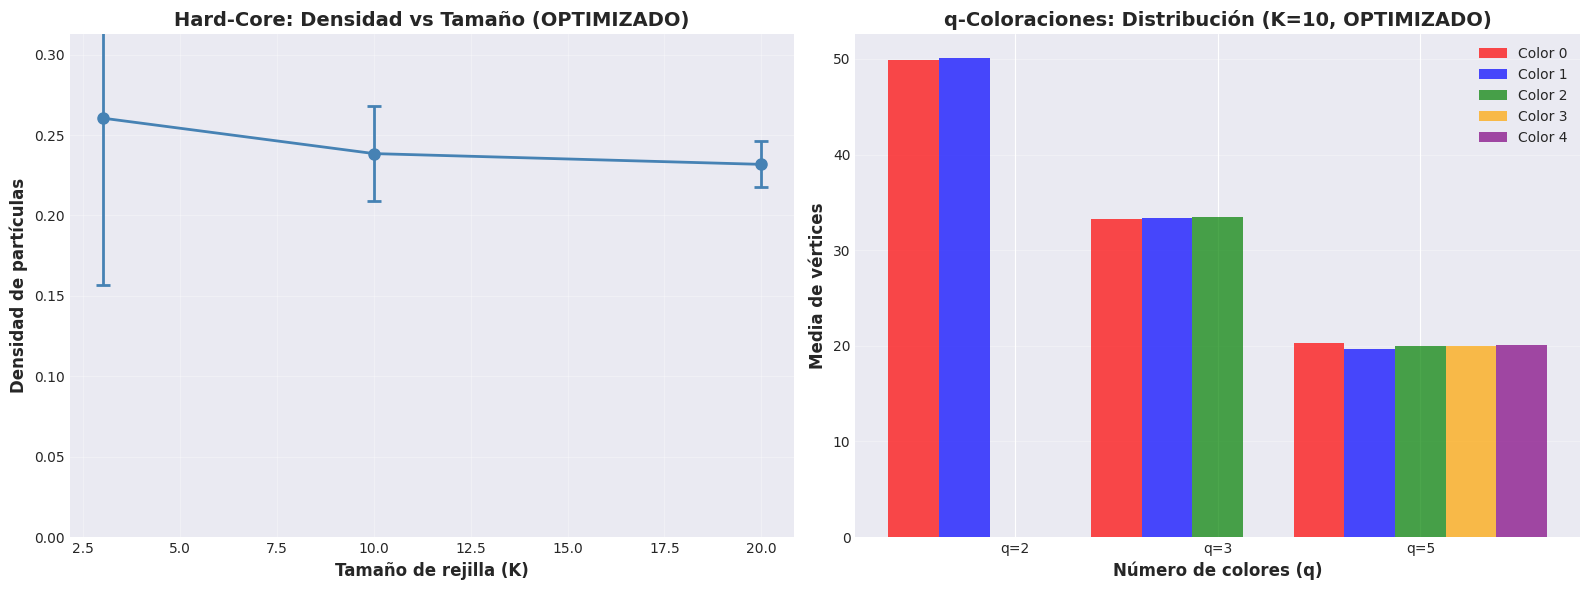

In [20]:
# Gráficas comparativas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: Densidad Hard-Core vs K
K_list = list(estadisticas_hardcore.keys())
densidades = [estadisticas_hardcore[K]['densidad'] for K in K_list]
stds = [estadisticas_hardcore[K]['std'] / (K * K) for K in K_list]

ax1.errorbar(K_list, densidades, yerr=stds, marker='o', markersize=8,
             linewidth=2, capsize=5, capthick=2, color='steelblue')
ax1.set_xlabel('Tamaño de rejilla (K)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densidad de partículas', fontsize=12, fontweight='bold')
ax1.set_title('Hard-Core: Densidad vs Tamaño (OPTIMIZADO)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(densidades) * 1.2)

# Gráfica 2: Distribución q-coloraciones
width = 0.25
x = np.arange(len(q_valores))
colores_barras = ['red', 'blue', 'green', 'orange', 'purple']
max_colores = max(q_valores)

for c in range(max_colores):
    medias = []
    for q in q_valores:
        if c < q:
            medias.append(estadisticas_coloracion[q][c]['media'])
        else:
            medias.append(0)
    
    offset = width * (c - max_colores/2 + 0.5)
    ax2.bar(x + offset, medias, width, label=f'Color {c}',
            color=colores_barras[c], alpha=0.7)

ax2.set_xlabel('Número de colores (q)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Media de vértices', fontsize=12, fontweight='bold')
ax2.set_title(f'q-Coloraciones: Distribución (K={K_color}, OPTIMIZADO)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'q={q}' for q in q_valores])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/comparativo_general.png', dpi=150, bbox_inches='tight')
plt.show()